Import Packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sgx_uuid = '04311cdc-a6a5-4d5e-916e-4e75076a8f0a'
spec_uuid = 'c92494ea-5e44-4507-8776-984705d1fd2b'

pollutant = ['O3', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10']
environment = ['RH', 'AMB_TEMP']


sgx_sensor_dict = {'c1_4#ec_na#0': 'O3',
                   'c1_0#ec_na#0': 'CO',
                   'c1_3#ec_na#0': 'NO2',
                   'c1_5#ec_na#0': 'SO2'}

unit_table = {'O3': 'ppb', 
              'CO': 'ppm',
              'NO2': 'ppb',
              'SO2': 'ppb'}



Some useful functions

In [2]:
def getData(file_path, device):
    try:
        df = pd.read_csv(file_path, usecols = ['measure_time', 'sensors'])
    except:
        return None
    df['measure_time'] = list(map(lambda x: datetime.strptime(x[:13], '%Y-%m-%dT%H') + timedelta(hours=8), df['measure_time']))
    
    if device == 'SGX':
        start = 7
    if device == 'SPEC':
        start = 6
        
    for i, gas in enumerate(pollutant[:4]):
        df[device + '-' + gas] = list(map(lambda x: json.loads(x)[start+i]['value'], df['sensors']))
    df = df.drop('sensors', axis=1)
    df = df.sort_values('measure_time')
    return df

def score(y_pred, y_true):
    print('***R2 Score: {:.2f}'.format(r2_score(y_pred, y_true)))
    print('***RMSE: {:.2f}'.format(math.sqrt(mean_squared_error(y_pred, y_true))))

def visualize_result(x, y_true, y_pred, dates, title):
    x = range(len(dates))
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    fig.suptitle(title)
    ax[0].plot(x, y_true, label = 'Reference')
    ax[0].plot(x, y_pred, label = 'Calibrated')
    ax[0].set_xticks(np.arange(0, len(dates), 50))
    ax[0].set_xticklabels(labels = dates[::50].date, rotation = 20)
    ax[0].legend()

    ax[1].scatter(y_pred, y_true)
    ax[1].plot([min(y_pred), max(y_pred)], [min(y_true), max(y_true)], 'g--', linewidth=2, markersize=12, label = 'ideal')
    ax[1].legend()
    ax[1].set_xlabel('Predict')
    ax[1].set_ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'fig/{title}', dpi=300, bbox_inches='tight')
    plt.show()

2023

In [3]:
ref = pd.concat([pd.read_csv(path, na_values='x') for path in glob.glob(os.path.join('3rdData', '2023', '*.csv'))])
ref['"monitordate"'] = ref['"monitordate"'].str[:13]
ref['"monitordate"'] = list(map(lambda x: datetime.strptime(x, '%Y-%m-%d %H'), ref['"monitordate"']))
ref = ref.drop_duplicates()
ref = ref.set_index('"monitordate"')
ref.index.name = None
ref_data = pd.concat([ref.loc[ref['"itemengname"'] == p, ['"concentration"']] for p in pollutant + environment], axis = 1)
ref_data.columns = ['REF-' + p for p in pollutant + environment]
ref_data = ref_data.dropna()
ref_data


,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-03-26 15:00:00,28.4,0.41,13.0,0.1,20.0,35.0,86.0,17.1
2023-03-26 16:00:00,28.1,0.43,14.2,0.0,21.0,40.0,86.0,17.0
2023-03-26 17:00:00,34.8,0.45,14.2,0.0,31.0,43.0,87.0,16.5
2023-03-26 18:00:00,42.6,0.39,11.5,0.1,19.0,41.0,85.0,16.5


SGX

In [4]:
paths = [p for p in glob.glob(os.path.join('deviceData', '*', '*.csv')) if sgx_uuid in p]
sgx_data = pd.concat([getData(path, 'SGX') for path in paths if getData(path, 'SGX') is not None])
print(f'Number of Samples: {len(sgx_data)}')
sgx_data = sgx_data.groupby('measure_time').mean()
# sgx_data.index = list(map(lambda x: x + timedelta(hours=1), sgx_data.index))
sgx_data

SPEC

In [8]:
paths = [p for p in glob.glob(os.path.join('deviceData', '*', '*.csv')) if spec_uuid in p]
spec_data = pd.concat([getData(path, 'SPEC') for path in paths if getData(path, 'SPEC') is not None])
print(f'Number of Samples: {len(spec_data)}')
spec_data = spec_data.groupby('measure_time').mean()
# spec_data.index = list(map(lambda x: x + timedelta(hours=1), spec_data.index))
spec_data

Number of Samples: 12372


,SPEC-O3,SPEC-CO,SPEC-NO2,SPEC-SO2
measure_time,,,,
2023-01-07 11:00:00,-2.386834,5.747358,-14.257812,71.975528
2023-01-07 12:00:00,-2.239583,6.233724,-14.397786,80.398763
2023-01-07 13:00:00,-2.301432,6.930339,-15.050456,90.367839
2023-01-07 14:00:00,-2.664388,5.748698,-14.055990,75.003255
2023-01-07 15:00:00,-2.438151,5.312500,-12.535807,66.230469
...,...,...,...,...
2023-02-22 12:00:00,-2.376302,3.222656,-11.621094,31.770833
2023-02-22 13:00:00,-2.392578,3.271484,-11.816406,32.324219
2023-02-22 14:00:00,-2.197266,3.271484,-12.109375,33.251953


Join the data

In [9]:
# start = datetime.strptime("2023-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
# end = datetime.strptime("2023-01-31 00:00:00", "%Y-%m-%d %H:%M:%S")
# date_generated = [start + timedelta(hours=1) for x in range(0, (end-start).hours)]

data = pd.concat([ref_data, sgx_data, spec_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)

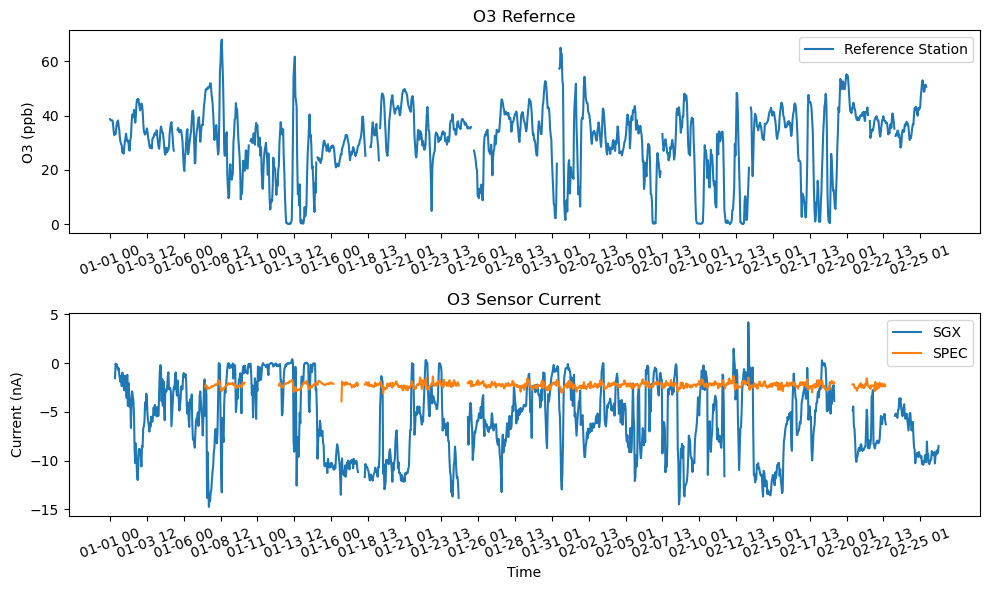

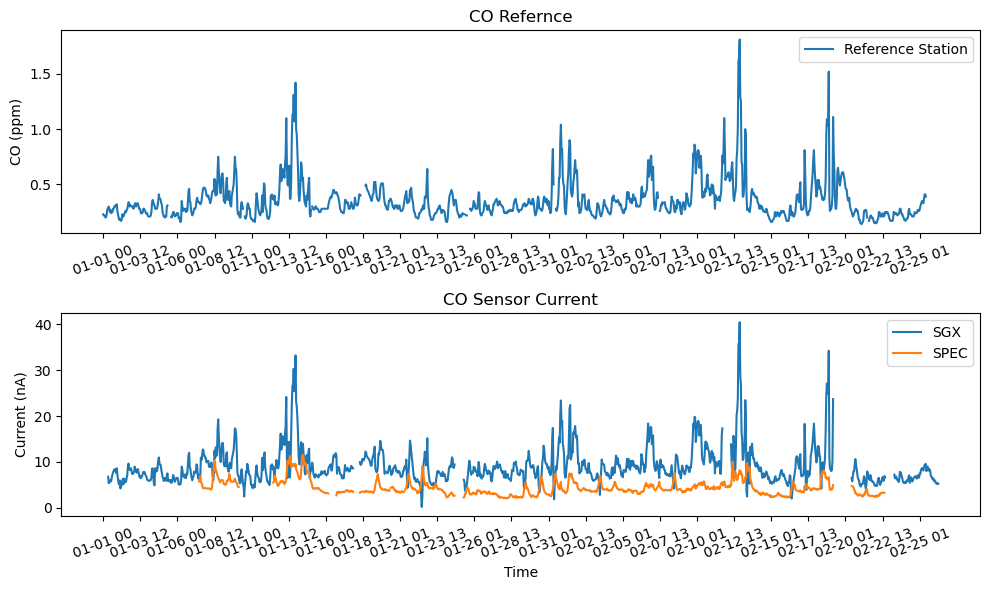

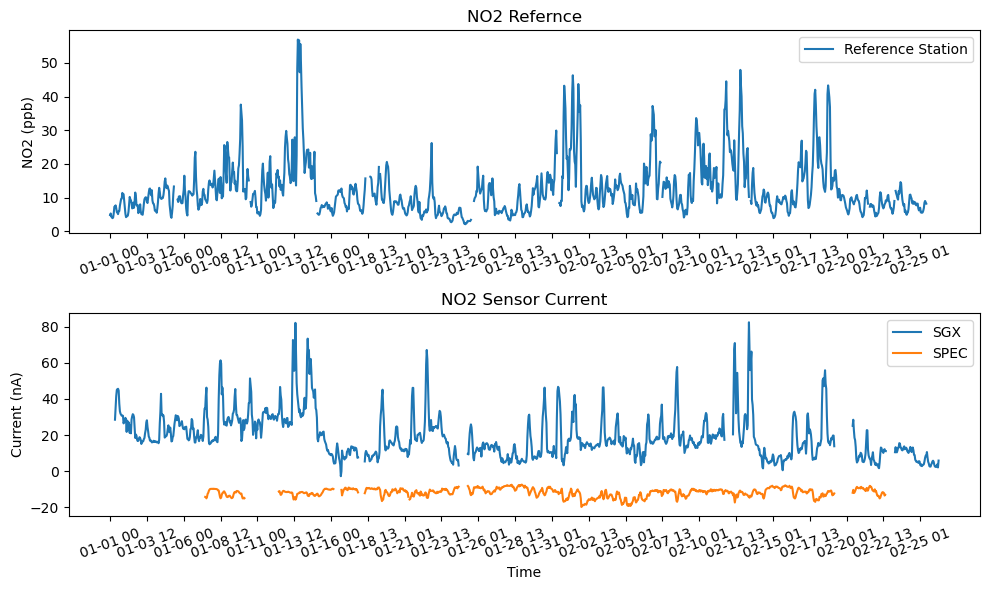

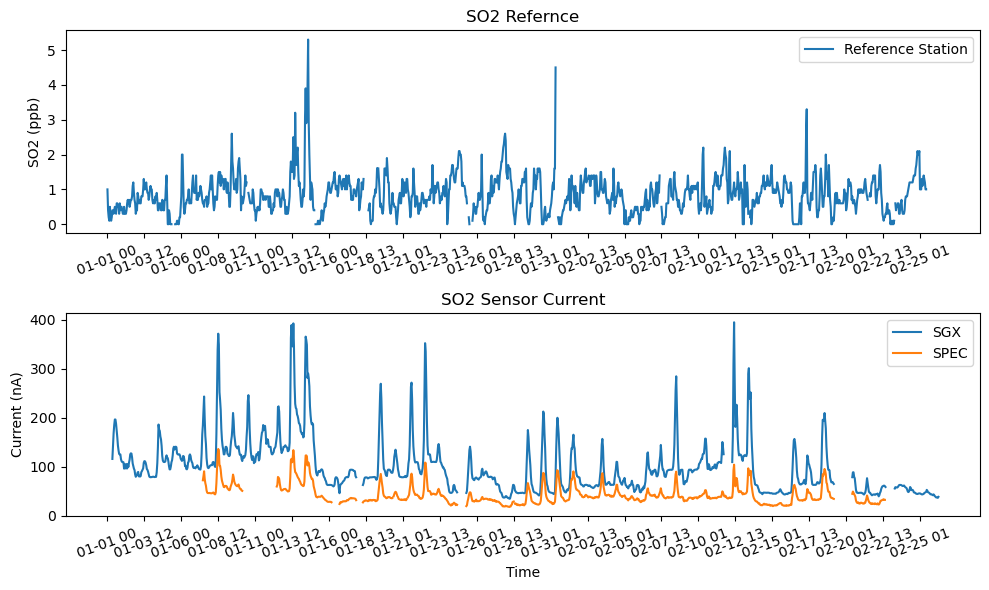

In [10]:
for gas in pollutant[:4]:
    labels = list(map(lambda x: str(x)[5:13], data.index[::60]))
    fig = plt.figure(figsize=(10, 6))

    ax1 = plt.subplot(211)
    ax1.set_title(f'{gas} Refernce')
    ax1.plot(data['REF-' + gas].values, label = 'Reference Station')
    ax1.legend()
    ax1.set_xticks(ticks = list(np.arange(0, len(data.index), 60)))
    ax1.set_xticklabels(labels = labels, rotation = 20)
    ax1.set_ylabel(f'{gas} ({unit_table[gas]})')
    

    ax2 = plt.subplot(212, sharex = ax1)
    ax2.set_title(f'{gas} Sensor Current')
    ax2.plot(data['SGX-' + gas].values, label = 'SGX')
    ax2.plot(data['SPEC-' + gas].values, label = 'SPEC')
    ax2.legend()
    ax2.set_xticks(ticks = list(np.arange(0, len(data.index), 60)))
    ax2.set_xticklabels(labels = labels, rotation = 20)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Current (nA)')

    plt.tight_layout()
    plt.savefig(f'fig/{gas}_comparison.png', dpi=300, bbox_inches='tight')


Correlation heatmap

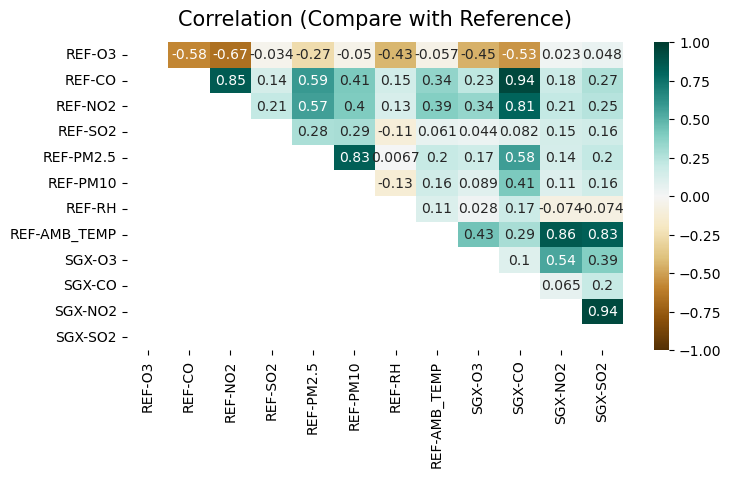

In [14]:
df = data.dropna().iloc[:, :12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.tril(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
heatmap.set_title('Correlation (Compare with Reference)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/correlation_heatmap_outer.png', dpi=300, bbox_inches='tight')

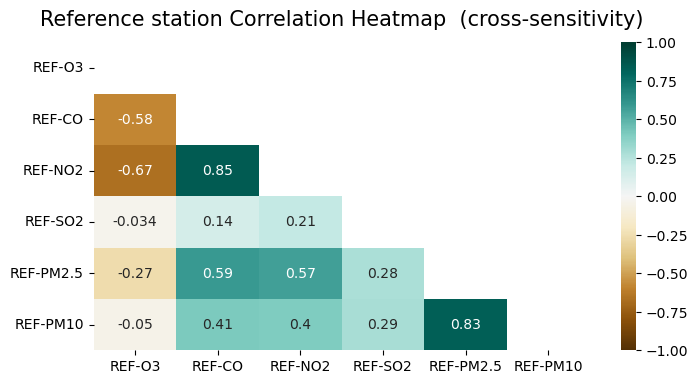

In [14]:
df = data.dropna().iloc[:, 0:6]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Reference station Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/ref_correlation_heatmap.png', dpi=300, bbox_inches='tight')

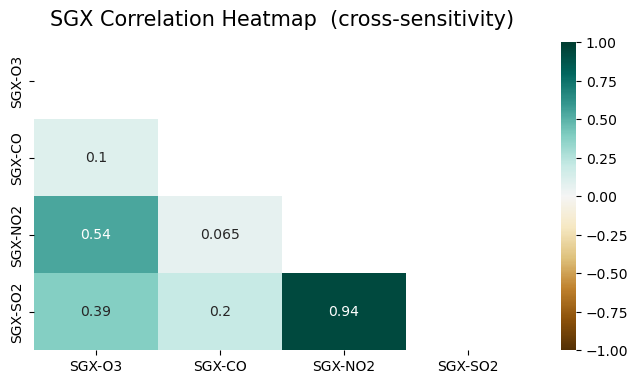

In [15]:
df = data.dropna().iloc[:, 8:12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('SGX Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/sgx_correlation_heatmap.png', dpi=300, bbox_inches='tight')

Target Gas & Settings

In [40]:
gas = 'SO2'
split = .8

Device Comparison - SGX

In [41]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index
train_dates = dates[:int(len(dates)*split)]
test_dates = dates[int(len(dates)*split):]

x_train = pd.concat([sgx_data.loc[train_dates, [f'SGX-{gas}', 'SGX-CO']], ref_data.loc[train_dates, ['REF-AMB_TEMP', 'REF-RH']]], axis = 1).values
y_train = ref_data.loc[train_dates, f'REF-{gas}'].values

x_test = pd.concat([sgx_data.loc[test_dates, [f'SGX-{gas}', 'SGX-CO']], ref_data.loc[test_dates, ['REF-AMB_TEMP', 'REF-RH']]], axis = 1).values
y_test = ref_data.loc[test_dates, f'REF-{gas}'].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(708, 4) (178, 4) (708,) (178,)


In [42]:
reg = LinearRegression().fit(x_train, y_train)
# reg = SVR(kernel='rbf').fit(x_train, y_train)

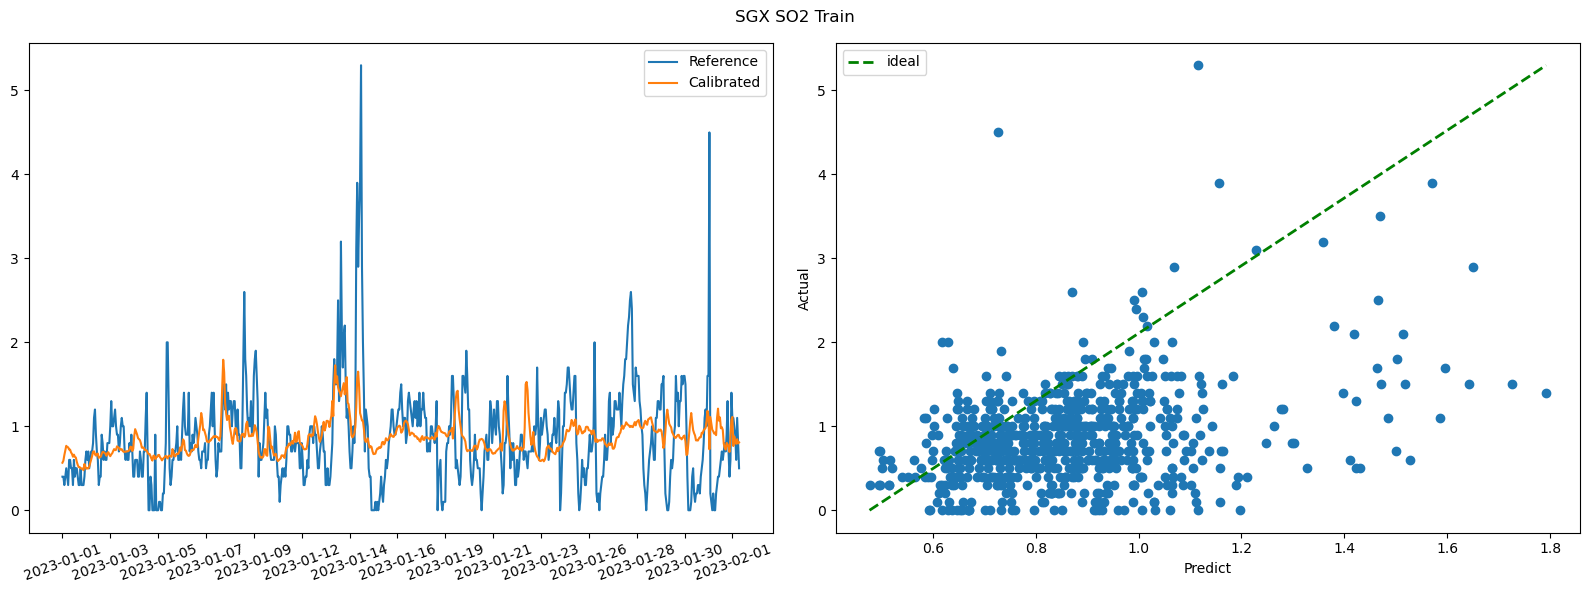

***R2 Score: -6.52
***RMSE: 0.54


In [43]:
y_pred = reg.predict(x_train)
visualize_result(x_train, y_train, y_pred, train_dates, title = f'SGX {gas} Train')
score(y_pred, y_train)

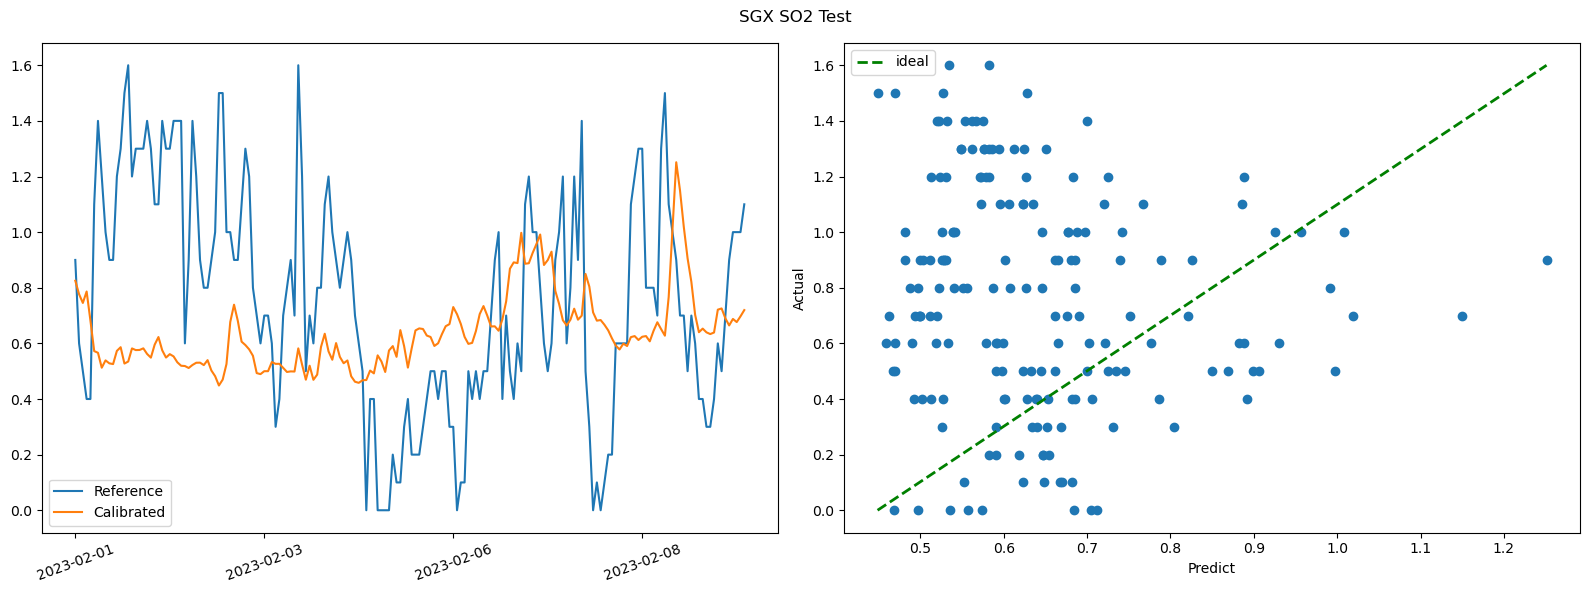

***R2 Score: -10.01
***RMSE: 0.45


In [44]:
y_pred = reg.predict(x_test)
visualize_result(x_test, y_test, y_pred, test_dates, title = f'SGX {gas} Test')
score(y_pred, y_test)

Device Comparison - SPEC

In [45]:
dates = spec_data.loc[spec_data.index.isin(ref_data.index), :].index
train_dates = dates[:int(len(dates)*split)]
test_dates = dates[int(len(dates)*split):]

x_train = pd.concat([spec_data.loc[train_dates, f'SPEC-{gas}'], ref_data.loc[train_dates, ['REF-RH', 'REF-AMB_TEMP']]], axis = 1).values
y_train = ref_data.loc[train_dates, f'REF-{gas}'].values

x_test = pd.concat([spec_data.loc[test_dates, f'SPEC-{gas}'], ref_data.loc[test_dates, ['REF-RH', 'REF-AMB_TEMP']]], axis = 1).values
y_test = ref_data.loc[test_dates, f'REF-{gas}'].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(540, 3) (135, 3) (540,) (135,)


In [46]:
reg = LinearRegression().fit(x_train, y_train)

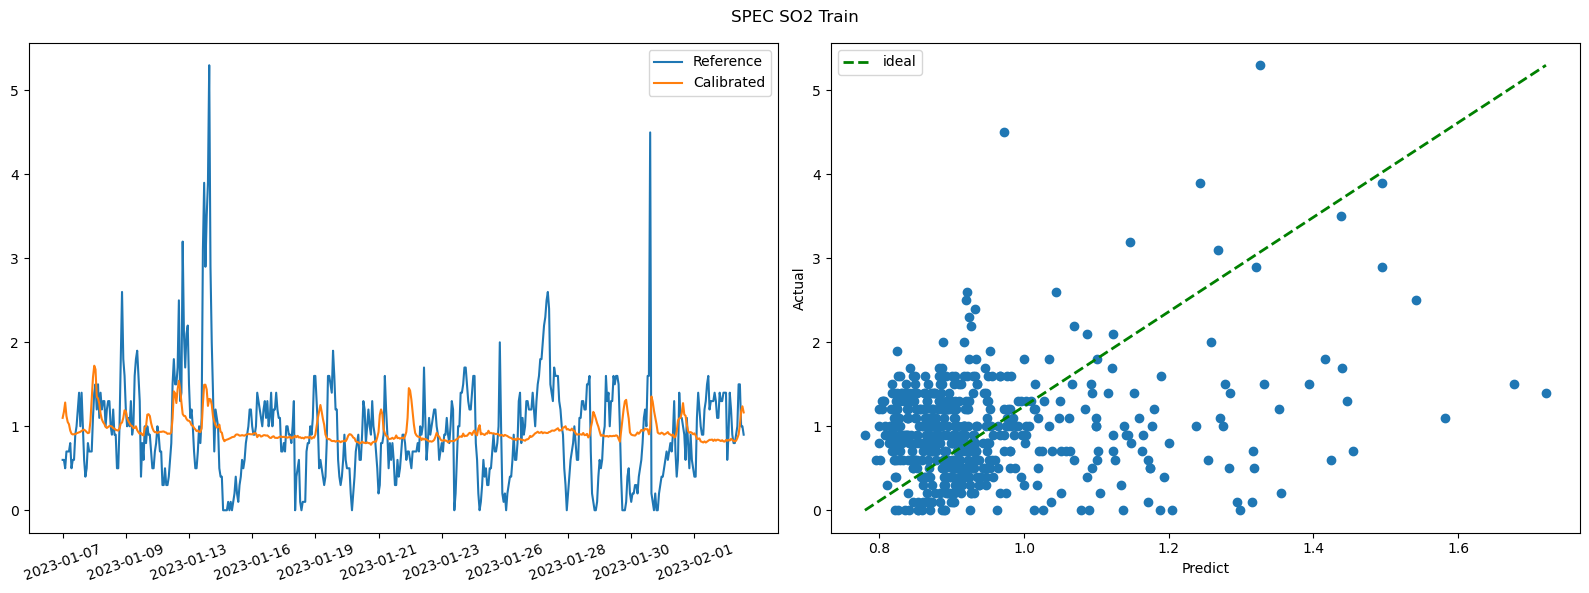

***R2 Score: -16.86
***RMSE: 0.60


In [47]:
y_pred = reg.predict(x_train)
visualize_result(x_train, y_train, y_pred, train_dates, title = f'SPEC {gas} Train')
score(y_pred, y_train)

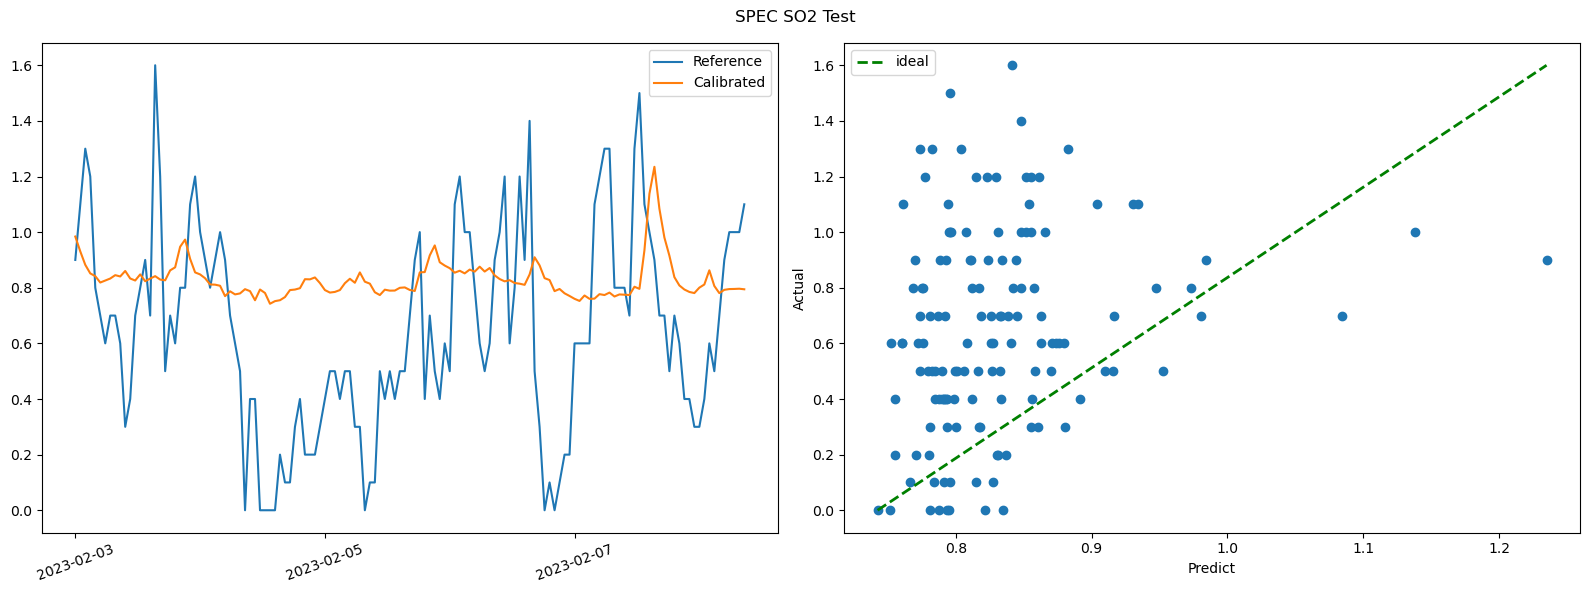

***R2 Score: -32.44
***RMSE: 0.40


In [48]:
y_pred = reg.predict(x_test)
visualize_result(x_test, y_test, y_pred, test_dates, title = f'SPEC {gas} Test')
score(y_pred, y_test)